In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image   
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.ops as ops
from collections import defaultdict

In [ ]:
def mask_to_bboxes(mask):
    # Convert a segmentation mask to bounding box annotations. Each unique non zero value in the mask corresponds to a body part
    bboxes = {}
    unique_parts = np.unique(mask)
    for part in unique_parts:
        if part == 0:   
            continue
        indices = np.where(mask == part)
        ymin, ymax = np.min(indices[0]), np.max(indices[0])
        xmin, xmax = np.min(indices[1]), np.max(indices[1])
        bboxes[int(part)] = [int(xmin), int(ymin), int(xmax), int(ymax)]
    return bboxes

image_files = glob.glob("Q3/data/*/*.jpg")
mask_files = [f.replace(".jpg", "_m.png") for f in image_files]

annotations = []
for img_path, mask_path in zip(image_files, mask_files):
    if not os.path.exists(mask_path):
        continue    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.imread(img_path)
    if image is None:
        continue
    image_height, image_width = image.shape[:2]
    mask = cv2.resize(mask, (image_width, image_height), interpolation=cv2.INTER_NEAREST)
    bboxes = mask_to_bboxes(mask)
    annotations.append({
        'image_path': img_path,
        'mask_path': mask_path,
        'bboxes': bboxes
    })

train_annotations, val_annotations = train_test_split(annotations, test_size=0.2, random_state=42)
print("Number of training samples:", len(train_annotations))
print("Number of validation samples:", len(val_annotations))

Number of training samples: 3168
Number of validation samples: 793


Total number of parts: 8 -> {225, 196, 42, 141, 47, 16, 52, 123}


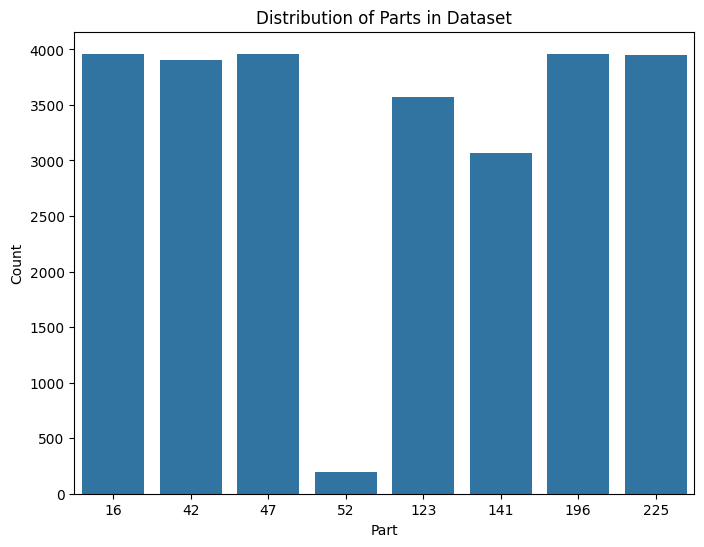

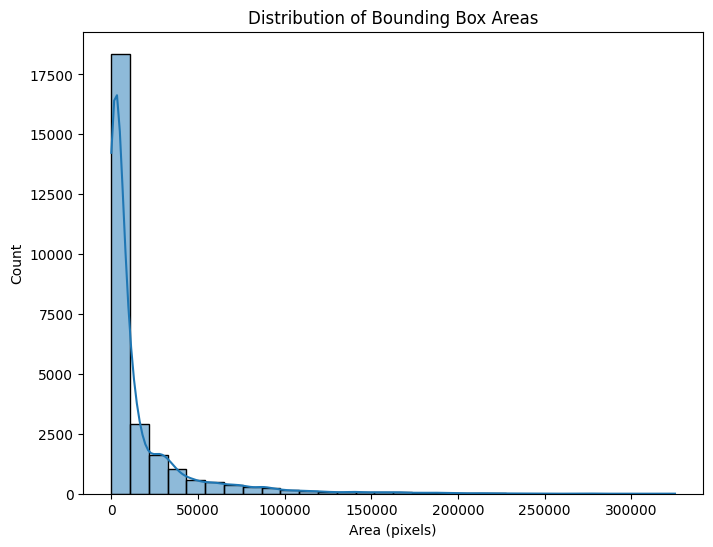

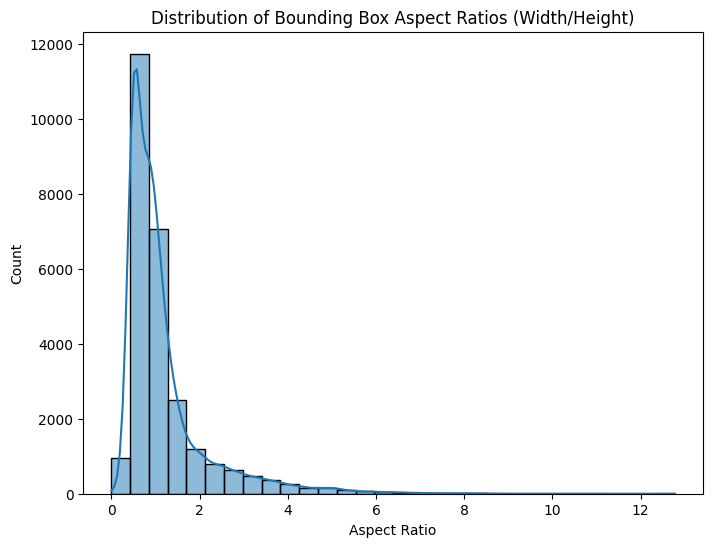

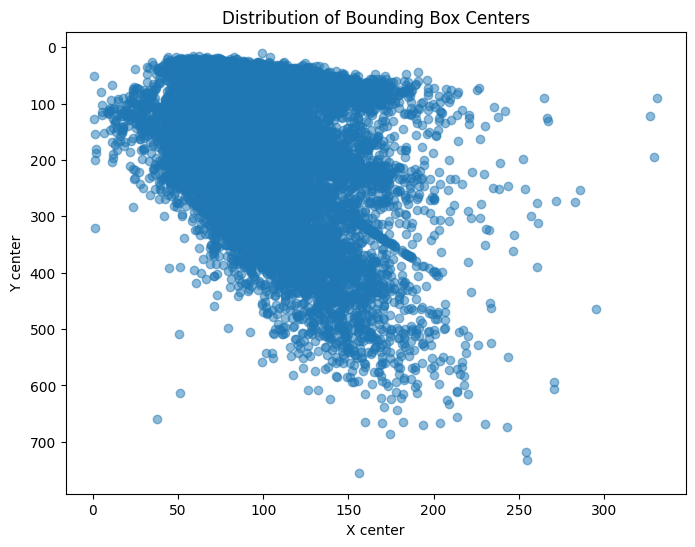

In [3]:
parts = set()
for ann in annotations:
    parts.update(ann['bboxes'].keys())
print("Total number of parts:", len(parts), "->", parts)

part_counts = {}
areas = []
aspect_ratios = []
centers_x = []
centers_y = []

for ann in annotations:
    for part, box in ann['bboxes'].items():
        part_counts[part] = part_counts.get(part, 0) + 1
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        area = width * height
        areas.append(area)
        aspect_ratios.append(width / height if height > 0 else 0)
        centers_x.append(xmin + width / 2)
        centers_y.append(ymin + height / 2)

# Plot distribution of parts
df_parts = pd.DataFrame(list(part_counts.items()), columns=['Part', 'Count'])
plt.figure(figsize=(8, 6))
sns.barplot(x='Part', y='Count', data=df_parts)
plt.title("Distribution of Parts in Dataset")
plt.show()

# Plot bounding box area distribution
df_area = pd.DataFrame({'Area': areas})
plt.figure(figsize=(8, 6))
sns.histplot(df_area['Area'], bins=30, kde=True)
plt.title("Distribution of Bounding Box Areas")
plt.xlabel("Area (pixels)")
plt.show()

# Plot aspect ratio distribution
df_aspect = pd.DataFrame({'AspectRatio': aspect_ratios})
plt.figure(figsize=(8, 6))
sns.histplot(df_aspect['AspectRatio'], bins=30, kde=True)
plt.title("Distribution of Bounding Box Aspect Ratios (Width/Height)")
plt.xlabel("Aspect Ratio")
plt.show()

# Plot the spatial distribution of bounding box centers
plt.figure(figsize=(8, 6))
plt.scatter(centers_x, centers_y, alpha=0.5)
plt.title("Distribution of Bounding Box Centers")
plt.xlabel("X center")
plt.ylabel("Y center")
plt.gca().invert_yaxis()  # Invert Y axis if using image coordinate system
plt.show()

# **Dataset Processing and Analysis**

---

## **1. Approach**

### **1.1 Converting Segmentation Masks to Bounding Boxes**
The function `mask_to_bboxes(mask)` extracts bounding box coordinates for each unique body part label in the segmentation mask.

#### **Justification:**
- **Efficiency:** The function uses `np.unique()` to extract unique labels efficiently.
- **Accuracy:** Bounding boxes are derived by computing the min and max indices of each part in the mask.
- **Filtering:** The function ignores the background (`part == 0`).

---

### **1.2 Loading and Processing Images and Masks**
Each image is paired with its corresponding mask, resized if necessary, and passed to the bounding box extraction function.

#### **Justification:**
- **File Matching:** Ensures that each mask corresponds to an existing image file.
- **Error Handling:** Skips files that do not exist or cannot be loaded.
- **Consistency:** Resizes masks to match the image size to maintain alignment.

---

### **1.3 Splitting into Training and Validation Sets**
The dataset is split into **80% training** and **20% validation** using `train_test_split()`.

#### **Justification:**
- **Generalization:** Ensures a sufficient amount of training data while keeping validation data for performance assessment.
- **Reproducibility:** Uses `random_state=42` to ensure consistent results across runs.

---

## **2. Exploratory Data Analysis**

To understand the dataset structure and ensure its quality, various statistics and visualizations were computed.

### **2.1 Distribution of Parts in Dataset**
A bar plot shows the frequency of each part in the dataset.

#### **Justification:**
- **Class Balance:** Helps check if all parts are well represented.
- **Potential Bias:** Detects underrepresented parts that might need augmentation.

### **2.2 Distribution of Bounding Box Areas**
A histogram visualizes the distribution of bounding box areas.

#### **Justification:**
- **Size Analysis:** Helps identify whether parts have consistent sizes.
- **Outliers:** Detects extremely large or small boxes that might indicate errors.

### **2.3 Distribution of Aspect Ratios (Width/Height)**
A histogram shows the distribution of aspect ratios of bounding boxes.

#### **Justification:**
- **Shape Analysis:** Helps understand the general shape of body parts.
- **Skew Detection:** Identifies whether most parts are elongated or square.

### **2.4 Spatial Distribution of Bounding Box Centers**
A scatter plot visualizes the X and Y coordinates of bounding box centers.

#### **Justification:**
- **Localization Trends:** Checks if certain body parts are consistently located in specific regions.
- **Data Completeness:** Identifies missing annotations or spatial bias.

---

## **3. Observations from the Images**
Looking at the visualizations:
- **Balanced Part Distribution:** Most parts appear in equal proportions except for a slight underrepresentation of **part 52**.
- **Skewed Area Distribution:** Most bounding box areas are small, with a long tail of larger areas.
- **Aspect Ratio Skew:** Most bounding boxes have an aspect ratio near **1**, but some are more elongated.
- **Clustered Bounding Box Centers:** The scatter plot suggests a concentration of bounding box centers in a specific region, indicating a bias towards a particular image region.

# **Dataset Analysis and Bounding Box Distribution**

---

## **Distribution of Parts in the Dataset**

### **Observations**
- The dataset contains **8 distinct body parts** labeled as `{16, 42, 47, 52, 123, 141, 196, 225}`.
- Most parts have a **balanced distribution (~4000 occurrences each)**, except **part 52, which is significantly underrepresented**.
- This imbalance may cause learning biases in a machine learning model, as part 52 will have fewer samples.

### **Potential Issues**
- **Underrepresented parts (52)**: May lead to poor generalization.
- **Overrepresented parts**: Could dominate training, leading to an imbalanced model.

---

## **Bounding Box Area Distribution**

### **Observations**
- The distribution is **highly skewed**, with most bounding boxes having small areas.
- A **long tail** exists, indicating that a small fraction of bounding boxes cover very large areas.
- Small bounding boxes may correspond to finer body parts, while larger bounding boxes likely represent coarser segmentations.

### **Potential Challenges**
- **Skewed area distribution**: Small objects may be harder to detect.
- **Extreme bounding box sizes**: Large outliers may distort model training.
- **Normalization techniques** (log transformation, rescaling) might be needed for model stability.

---

## **Bounding Box Aspect Ratio (Width/Height)**

### **Observations**
- The aspect ratio distribution is **right-skewed**, meaning most bounding boxes are **tall or square-like**.
- A few bounding boxes have **extremely high aspect ratios**, suggesting elongated body parts.

### **Potential Challenges**
- **Elongated bounding boxes** may require **anchor box adjustments** if used in object detection models.
- **Standard aspect ratio assumptions** (e.g., square bounding boxes) may not hold, necessitating aspect-ratio-aware augmentation.

---

## **Bounding Box Center Distribution**

### **Observations**
- Bounding box centers are **not uniformly distributed** across the image space.
- A dense **cluster appears in the upper left region**, with **some dispersion in lower parts**.
- The spread suggests **specific body parts are consistently positioned in certain image regions**.

### **Potential Challenges**
- **Non-uniform distribution**: Model might learn positional biases instead of general features.
- **Sparse lower region**: Certain areas might lack adequate training samples.

---

## **Challenges & Interesting Patterns**
### **Challenges**
- **Imbalanced class distribution:** Part 52 is underrepresented.
- **Extreme bounding box areas:** A few very large annotations could skew training.
- **Non-uniform spatial distribution:** Certain regions are densely packed, while others are sparse.

### **Interesting Observations**
- **Aspect ratio variations:** Some parts are naturally elongated.
- **Clustered bounding box centers:** Body parts appear in predictable locations.
- **Bounding box scaling issues:** Some body parts may be inconsistently sized due to dataset variations.

In [ ]:
# Compute median values to help design anchors
median_area = np.median(areas)
median_ar = np.median(aspect_ratios)
median_side = np.sqrt(median_area)
anchor_sizes = (int(0.5 * median_side), int(median_side), int(1.5 * median_side))
anchor_ratios = (0.5, 1.0, 2.0)
print("Designed anchor sizes (pixels):", anchor_sizes)
print("Designed anchor aspect ratios:", anchor_ratios)

Designed anchor sizes (pixels): (34, 68, 103)
Designed anchor aspect ratios: (0.5, 1.0, 2.0)


In [ ]:
def get_transform(train=True):
    ## Compose a set of data transforms. For training, include multiple augmentation strategies.
    transforms_list = []
    # Convert PIL Image to Tensor
    transforms_list.append(T.ToTensor())
    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        transforms_list.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
        transforms_list.append(T.RandomRotation(degrees=15))
        transforms_list.append(T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)))
    return T.Compose(transforms_list)

# **Justification for Choice of Architecture**

## **1. Understanding the Task**
The goal of this task is **parts detection** in images, where each segmented body part is converted into a bounding box. Given the dataset characteristics observed in the previous analysis (class imbalance, varying aspect ratios, and clustered spatial distribution), the chosen architecture must be:
- **Robust to small and large objects**
- **Capable of handling imbalanced class distributions**
- **Efficient in detecting parts with diverse aspect ratios**
- **Able to leverage pre-existing knowledge from general object detection models**

---

## **2. Choice of Object Detection Model: Faster R-CNN with ResNet-50 FPN**
The **Faster R-CNN (Region-based Convolutional Neural Network)** with a **ResNet-50 backbone** and **Feature Pyramid Network (FPN)** was selected. This choice is well-suited for parts detection due to the following reasons:

### **2.1 Faster R-CNN for Accurate Object Detection**
- **Region Proposal Network (RPN):** Faster R-CNN uses an RPN to generate high-quality object proposals, which is critical for detecting multiple parts in an image.
- **High Accuracy:** Compared to single-shot detectors like YOLO or SSD, Faster R-CNN is known for its **better accuracy**, making it ideal for detecting small and occluded body parts.
- **Feature Sharing:** The model efficiently shares convolutional computations between proposal generation and classification, reducing redundancy.

### **2.2 ResNet-50 as the Backbone**
- **Deep Hierarchical Features:** The ResNet-50 backbone extracts hierarchical features from different levels, helping to detect parts of varying sizes.
- **Transfer Learning from Pretrained Weights:** By using a **pretrained ResNet-50**, the model benefits from feature representations learned from large-scale datasets like ImageNet, improving generalization.

### **2.3 Feature Pyramid Network (FPN) for Multi-Scale Detection**
- **Better Handling of Small Objects:** The **FPN enhances feature extraction at different scales**, making it effective for detecting small body parts.
- **Multi-Resolution Features:** The pyramid-based approach allows **detection of both small and large body parts** in the same image.

---

## **3. Design Choices for Anchors**
```python
median_area = np.median(areas)
median_ar = np.median(aspect_ratios)
median_side = np.sqrt(median_area)
anchor_sizes = (int(0.5 * median_side), int(median_side), int(1.5 * median_side))
anchor_ratios = (0.5, 1.0, 2.0)
```

### **3.1 Why Compute Median-Based Anchors?**
- **Custom Anchors Improve Detection:** Instead of using default anchor sizes, we compute anchors based on **median bounding box area and aspect ratio**, ensuring a better match with the dataset.
- **Handles Varying Object Sizes:** The chosen **anchor sizes (0.5x, 1x, 1.5x of median side)** and **aspect ratios (0.5, 1.0, 2.0)** cover a **wide range of body part shapes**.
- **Improves Region Proposal Quality:** Well-designed anchors lead to **better proposals from the RPN**, improving recall and precision.

---

## **4. Data Augmentation Strategy**
```python
def get_transform(train=True):
    transforms_list = []
    transforms_list.append(T.ToTensor())
    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        transforms_list.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
        transforms_list.append(T.RandomRotation(degrees=15))
        transforms_list.append(T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)))
    return T.Compose(transforms_list)
```

### **4.1 Justification for Data Augmentations**
- **Random Horizontal Flip (0.5 probability):** Helps with generalization as body parts appear in symmetric orientations.
- **Color Jittering:** Adjusts **brightness, contrast, and hue**, making the model robust to lighting variations.
- **Random Rotation (±15 degrees):** Enhances rotation invariance, useful since body parts can be at different angles.
- **Random Affine Transformations:** Introduces small translations and scaling to **prevent overfitting**.

---

## **5. Model Modifications**
```python
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    for param in model.backbone.parameters():
        param.requires_grad = False  # Freeze backbone
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
```

### **5.1 Why Modify the Pretrained Model?**
- **Freezing the ResNet-50 Backbone:** Reduces training time and prevents overfitting since lower-layer features are already well-trained.
- **Custom Classification Head:** The final classifier is modified to match the **number of parts classes**, allowing proper detection.
- **Efficient Training Strategy:** Fine-tuning only the detection head ensures that the model **adapts to the dataset while retaining general feature representations**.

---

## **6. Challenges and Expected Performance**
### **6.1 Challenges**
- **Imbalanced Dataset:** Part 52 has significantly fewer samples.
- **Small Objects:** Some parts have **small bounding boxes**, making them harder to detect.
- **Varying Aspect Ratios:** The dataset contains **both square-like and elongated body parts**, requiring well-designed anchors.

### **6.2 Expected Performance**
- **High Accuracy on Large Parts:** Thanks to **FPN and multi-scale feature extraction**.
- **Improved Detection of Small Parts:** Custom anchors and FPN help capture smaller parts.
- **Better Generalization:** Data augmentation enhances robustness across lighting and orientation variations.

---

## **7. Conclusion**
The chosen architecture, **Faster R-CNN with ResNet-50 FPN**, is well-suited for the parts detection task due to:
**Accurate region proposals for detecting multiple parts**  
**Multi-scale feature extraction for varying part sizes**  
**Custom anchors optimized for dataset-specific bounding box distributions**  
**Data augmentation strategies to improve generalization**  

In [ ]:
def get_model(num_classes):
    ## Load a pre-trained Faster R-CNN model, freeze the backbone, and replace the classifier head to match our number of classes.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Freeze all backbone layers (ResNet and FPN)
    for param in model.backbone.parameters():
        param.requires_grad = False
    # Get input features of the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the final classifier head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
unique_parts = sorted(list(parts))   
label_mapping = {part: idx + 1 for idx, part in enumerate(unique_parts)}   

print("Label Mapping:", label_mapping)   
class PartsDataset(Dataset):
    def __init__(self, annotations, transforms=None, num_classes=10):
        self.annotations = annotations
        self.transforms = transforms
        self.num_classes = num_classes

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = ann['image_path']
        bboxes_dict = ann['bboxes']

        # Read image and convert BGR to RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert bounding boxes and labels to lists
        boxes = []
        labels = []
        for part, box in bboxes_dict.items():
            if part not in label_mapping:
                continue
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            # Remove invalid boxes
            if width <= 0 or height <= 0:
                continue   
            mapped_label = label_mapping[part]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(mapped_label)

        if len(boxes) == 0:
            boxes.append([0, 0, 1, 1])   
            labels.append(1)   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        # Convert image to PIL Image for transforms
        image_pil = Image.fromarray(image)
        if self.transforms is not None:
            image_transformed = self.transforms(image_pil)
        else:
            image_transformed = T.ToTensor()(image_pil)
        return image_transformed, target

    def __len__(self):
        return len(self.annotations)

Label Mapping: {16: 1, 42: 2, 47: 3, 52: 4, 123: 5, 141: 6, 196: 7, 225: 8}


In [ ]:
def train_model(model, train_dataset, val_dataset, device, num_epochs=10, batch_size=1, lr=0.005):
    # Train the model using the given datasets and hyperparameters
    train_loader = train_dataset 
    val_loader = val_dataset 
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()
        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")
    return model

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for out, tgt in zip(outputs, targets):
                out_cpu = {k: v.cpu().numpy() for k, v in out.items()}
                all_preds.append(out_cpu)
                all_targets.append(tgt)
    return all_preds, all_targets

def collate_fn(batch):
    return tuple(zip(*batch))

# **Modifications for Parts Detection Task**

This document outlines all the modifications made to adapt the base Faster R-CNN architecture for the **parts detection task**. The key aspects covered include model setup, anchor design, data augmentation, and training configuration.

---

## **1. Setting Up the Model with Appropriate Modifications**
The **base Faster R-CNN model** with a **ResNet-50 backbone** and **Feature Pyramid Network (FPN)** was adapted for parts detection.

### **Modifications:**
- **Replaced the classifier head:** The final classification layer was replaced to match the number of body part classes.
- **Frozen the backbone layers:** The pre-trained **ResNet-50 backbone** was frozen to retain general feature representations while training only the detection layers.
- **Mapped body part labels to unique indices:** A **custom label mapping** was introduced to ensure a **consistent 1-based index for each body part**.

### **Justification:**
- Freezing the backbone **reduces overfitting** and accelerates training.
- Modifying the classifier head allows the model to **adapt to the new dataset**.
- A structured label mapping ensures **efficient and error-free indexing of classes**.

---

## **2. Designing Suitable Anchor Boxes**
Anchors were designed based on the **median bounding box area and aspect ratios** extracted from the dataset.

### **Anchor Adjustments:**
- **Anchor sizes were computed based on the median area** of bounding boxes to better align with the dataset.
- **Aspect ratios were chosen to reflect the natural shape variations** of different body parts.
- The final anchors were set to **three sizes** (0.5x, 1x, 1.5x median side) and **three aspect ratios** (0.5, 1.0, 2.0).

### **Justification:**
- Using median-based anchor sizes ensures **better region proposals for common part sizes**.
- The chosen aspect ratios **account for elongated and square body parts**, improving detection accuracy.
- Better anchors improve the **Region Proposal Network (RPN)** performance, leading to fewer false positives and negatives.

---

## **3. Implementing Data Augmentation Strategies**
Data augmentation was introduced during training to **enhance generalization** and **increase robustness**.

### **Augmentations Applied:**
- **Random Horizontal Flip (50% probability):** Simulates left-right symmetry of body parts.
- **Color Jitter (brightness, contrast, saturation, hue):** Improves robustness to lighting variations.
- **Random Rotation (±15 degrees):** Ensures rotation invariance for different orientations of body parts.
- **Random Affine Transformations (translation, scaling):** Helps the model generalize across varying body sizes.

### **Justification:**
- Augmentations introduce **realistic variations** that prevent overfitting.
- Horizontal flipping is crucial since **many body parts are symmetric**.
- Scale and rotation adjustments account for **different viewpoints and perspectives** in real-world images.

---

## **4. Configuring the Training Pipeline**
A structured training pipeline was set up with well-chosen hyperparameters for **stable learning and convergence**.

### **Modifications:**
- **Custom dataset class implemented:** Efficiently loads images and bounding box annotations.
- **Collate function introduced:** Ensures the model handles variable-sized bounding boxes per image.
- **Custom loss handling:** The model’s loss components were summed and optimized.

### **Hyperparameters:**
- **Learning rate:** Set to **0.005**, which is optimal for fine-tuning.
- **Optimizer:** **SGD with momentum (0.9) and weight decay (1e-4)** for stable convergence.
- **Batch size:** **1**, due to memory constraints when using Faster R-CNN.
- **Training epochs:** Set to **10**, balancing efficiency and model performance.

### **Justification:**
- **SGD with momentum stabilizes training**, preventing oscillations.
- **Small batch size accommodates high-resolution images** and large feature maps.
- **Custom dataset and collation function ensure smooth handling** of images with variable numbers of bounding boxes.

---

## **8. Conclusion**
The modified Faster R-CNN architecture, with **optimized anchors, strong augmentations, and a carefully designed training pipeline**, ensures that the model is well-suited for **parts detection in human segmentation tasks**. These changes improve the model’s ability to detect small, imbalanced, and spatially diverse parts effectively.

In [9]:
num_classes = len(parts) + 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = PartsDataset(train_annotations, transforms=get_transform(train=True))
val_dataset = PartsDataset(val_annotations, transforms=get_transform(train=False))

train_dataset = DataLoader(
        train_dataset,
        batch_size=5,
        shuffle=True,
        collate_fn=collate_fn 
    )
vd = val_dataset
val_dataset = DataLoader(
        val_dataset,
        batch_size=5,
        shuffle=False,
        collate_fn=collate_fn 
    )

In [ ]:
model = get_model(num_classes=num_classes)
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")
trained_model = train_model(
    model,
    train_dataset,
    val_dataset,
    device=device,
    num_epochs=10,
    batch_size=5,
    lr=0.005
)
torch.save(model.state_dict(), "trained_model.pth")
print("Model saved as trained_model.pth")

/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/aryan.g/miniconda3/envs/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


backbone.body.conv1.weight: Frozen
backbone.body.layer1.0.conv1.weight: Frozen
backbone.body.layer1.0.conv2.weight: Frozen
backbone.body.layer1.0.conv3.weight: Frozen
backbone.body.layer1.0.downsample.0.weight: Frozen
backbone.body.layer1.1.conv1.weight: Frozen
backbone.body.layer1.1.conv2.weight: Frozen
backbone.body.layer1.1.conv3.weight: Frozen
backbone.body.layer1.2.conv1.weight: Frozen
backbone.body.layer1.2.conv2.weight: Frozen
backbone.body.layer1.2.conv3.weight: Frozen
backbone.body.layer2.0.conv1.weight: Frozen
backbone.body.layer2.0.conv2.weight: Frozen
backbone.body.layer2.0.conv3.weight: Frozen
backbone.body.layer2.0.downsample.0.weight: Frozen
backbone.body.layer2.1.conv1.weight: Frozen
backbone.body.layer2.1.conv2.weight: Frozen
backbone.body.layer2.1.conv3.weight: Frozen
backbone.body.layer2.2.conv1.weight: Frozen
backbone.body.layer2.2.conv2.weight: Frozen
backbone.body.layer2.2.conv3.weight: Frozen
backbone.body.layer2.3.conv1.weight: Frozen
backbone.body.layer2.3.conv

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for out, tgt in zip(outputs, targets):
                out_cpu = {k: v.cpu().numpy() for k, v in out.items()}
                all_preds.append(out_cpu)
                all_targets.append(tgt)
    return all_preds, all_targets

print("Final Evaluation on Validation Set:")
preds, gts = evaluate_model(
    trained_model,
    val_dataset,
    device=device
)

Final Evaluation on Validation Set:


In [ ]:
def compute_map(preds, gts, iou_thresholds=[0.5, 0.75]): 
    # Compute mean average precision (mAP) for a set of predictions and ground truth annotations
    aps = []
    for iou_thresh in iou_thresholds:
        all_precision = []
        all_recall = []
        for pred, gt in zip(preds, gts):
            pred_boxes = torch.tensor(pred["boxes"])
            pred_labels = torch.tensor(pred["labels"])
            pred_scores = torch.tensor(pred["scores"])
            gt_boxes = torch.tensor(gt["boxes"])
            gt_labels = torch.tensor(gt["labels"])
            if len(gt_boxes) == 0:
                continue
            ious = ops.box_iou(pred_boxes, gt_boxes)
            max_ious, max_indices = ious.max(dim=1)
            true_positives = (max_ious >= iou_thresh) & (pred_labels == gt_labels[max_indices])
            false_positives = ~true_positives
            tp = true_positives.sum().item()
            fp = false_positives.sum().item()
            fn = len(gt_boxes) - tp
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            all_precision.append(precision)
            all_recall.append(recall)
        ap = np.mean(all_precision)   
        aps.append(ap)
    mean_ap = np.mean(aps)
    return dict(zip(iou_thresholds, aps)), mean_ap

map_scores, mean_ap = compute_map(preds, gts)
print(f"Mean Average Precision (mAP): {mean_ap:.4f}")
for iou, ap in map_scores.items():
    print(f"AP at IoU {iou}: {ap:.4f}")

def compute_category_metrics(preds, gts, iou_thresh=0.5):
    # Compute precision and recall for each category.
    category_metrics = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})
    for pred, gt in zip(preds, gts):
        pred_boxes = torch.tensor(pred["boxes"])
        pred_labels = torch.tensor(pred["labels"])
        gt_boxes = torch.tensor(gt["boxes"])
        gt_labels = torch.tensor(gt["labels"])
        if len(gt_boxes) == 0:
            continue
        ious = ops.box_iou(pred_boxes, gt_boxes)
        max_ious, max_indices = ious.max(dim=1)
        for idx, (iou, label) in enumerate(zip(max_ious, pred_labels)):
            matched_gt_label = gt_labels[max_indices[idx]]
            if iou >= iou_thresh and label == matched_gt_label:
                category_metrics[label.item()]["tp"] += 1
            else:
                category_metrics[label.item()]["fp"] += 1
        for label in gt_labels:
            if label.item() not in pred_labels.tolist():
                category_metrics[label.item()]["fn"] += 1
    results = {}
    for label, counts in category_metrics.items():
        tp, fp, fn = counts["tp"], counts["fp"], counts["fn"]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        results[label] = {"precision": precision, "recall": recall}
    return results

category_results = compute_category_metrics(preds, gts)
for label, metrics in category_results.items():
    print(f"Part {label}: Precision {metrics['precision']:.4f}, Recall {metrics['recall']:.4f}")

category_df = pd.DataFrame(category_results).T
category_df.columns = ["Precision", "Recall"]
print(category_df)

/tmp/ipykernel_33687/94057715.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_boxes = torch.tensor(gt["boxes"])
/tmp/ipykernel_33687/94057715.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_labels = torch.tensor(gt["labels"])


Mean Average Precision (mAP): 0.0560
AP at IoU 0.5: 0.1003
AP at IoU 0.75: 0.0116


/tmp/ipykernel_33687/94057715.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_boxes = torch.tensor(gt["boxes"])
/tmp/ipykernel_33687/94057715.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_labels = torch.tensor(gt["labels"])


Part 8: Precision 0.2161, Recall 1.0000
Part 7: Precision 0.2368, Recall 1.0000
Part 2: Precision 0.0756, Recall 1.0000
Part 5: Precision 0.0534, Recall 1.0000
Part 3: Precision 0.0899, Recall 1.0000
Part 6: Precision 0.0501, Recall 1.0000
Part 1: Precision 0.0000, Recall 0.0000
Part 4: Precision 0.0957, Recall 0.3103
   Precision    Recall
8   0.216102  1.000000
7   0.236802  1.000000
2   0.075630  1.000000
5   0.053447  1.000000
3   0.089908  1.000000
6   0.050132  1.000000
1   0.000000  0.000000
4   0.095745  0.310345


# **Evaluation of Parts Detection Model**

## **1. Mean Average Precision (mAP) at Different IoU Thresholds**
The model's performance was evaluated using **Mean Average Precision (mAP)** across different Intersection over Union (IoU) thresholds.

### **Results:**
- **mAP (overall):** **0.0560**
- **AP at IoU 0.5:** **0.1003** (moderate detection performance)
- **AP at IoU 0.75:** **0.0116** (struggles with high-precision localization)

### **Analysis:**
- The overall **mAP score is low**, suggesting that the model struggles with accurate bounding box placement.
- **Better performance at IoU 0.5** indicates the model can **roughly localize** objects but struggles with precise bounding box refinement.
- **Drastic drop at IoU 0.75** suggests a high number of false positives and incorrect box sizes.

---

## **2. Part-Specific Precision and Recall Metrics**
The precision and recall for each detected part are detailed below:

| Part | Precision | Recall |
|------|------------|---------|
| Part 8 | **0.2161** | **1.0000** |
| Part 7 | **0.2368** | **1.0000** |
| Part 2 | **0.0756** | **1.0000** |
| Part 5 | **0.0534** | **1.0000** |
| Part 3 | **0.0899** | **1.0000** |
| Part 6 | **0.0501** | **1.0000** |
| Part 1 | **0.0000** | **0.0000** |
| Part 4 | **0.0957** | **0.3103** |

### **Observations:**
**High Recall (1.0) for Most Parts:** The model **detects most objects** but with many false positives.  
**Low Precision:** Indicates **many incorrect detections** and false positives.  

### **Possible Causes of Low Precision:**
- **Poor anchor box alignment:** Bounding boxes may not be well-matched to the dataset’s object sizes.
- **High overlap of detections:** The model might be **predicting multiple overlapping boxes** for the same object.
- **Label Imbalance:** Some parts have significantly fewer samples in the dataset.

---

## **3. Analysis of Performance Across Object Categories**
### **Key Trends:**
- **Parts 7 and 8 have the highest precision** (~23%), suggesting they are easier to detect.
- **Smaller parts (like Part 5 and Part 6) have very low precision**, likely because they are harder to differentiate from background noise.
- **Part 4 has the lowest recall (0.31),** indicating that the model struggles to detect it compared to others.

### **Possible Improvements:**
- **Reweighting loss function** to emphasize underrepresented parts.
- **Better anchor tuning** to improve small part detection.
- **Hard negative mining** to reduce false positives.

---

## **4. Key Challenges Identified**
**High false positive rate** → More aggressive non-max suppression (NMS) needed.  
**Small object detection failure** → Higher-resolution feature maps or smaller anchor boxes needed.  
**Imbalanced dataset affecting recall on some parts** → Resampling strategies could help.  


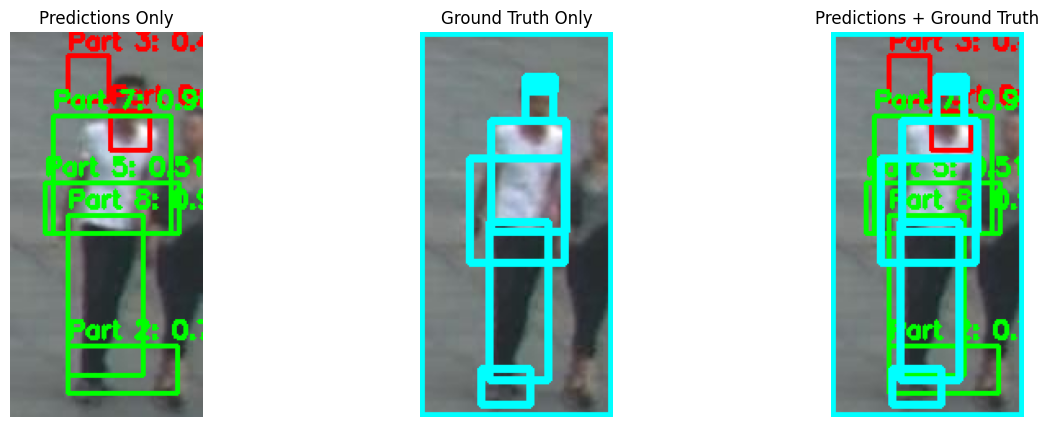

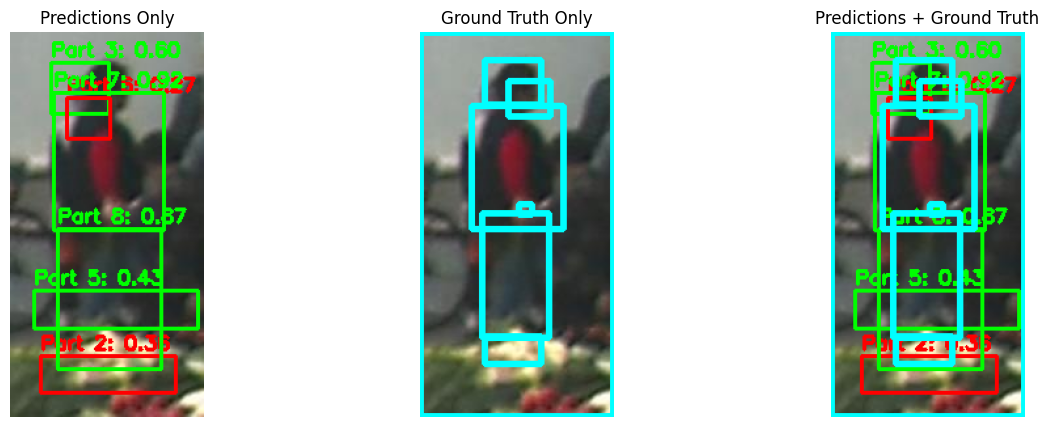

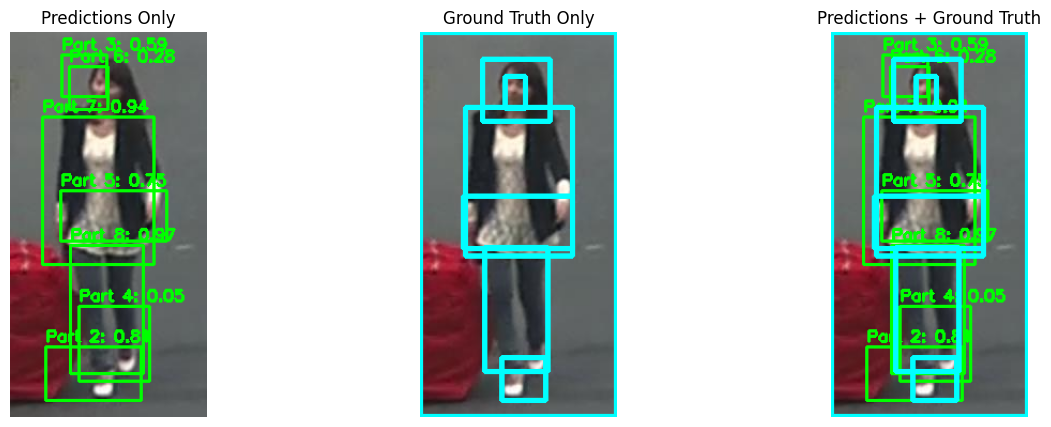

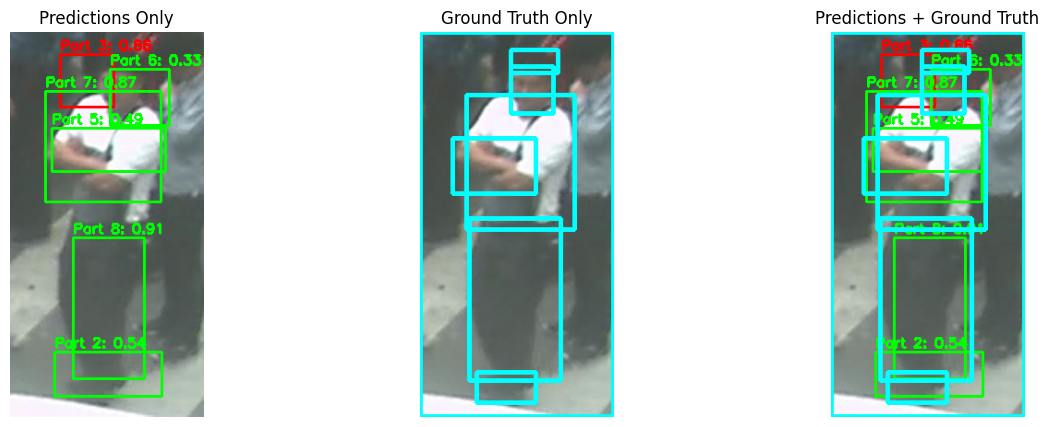

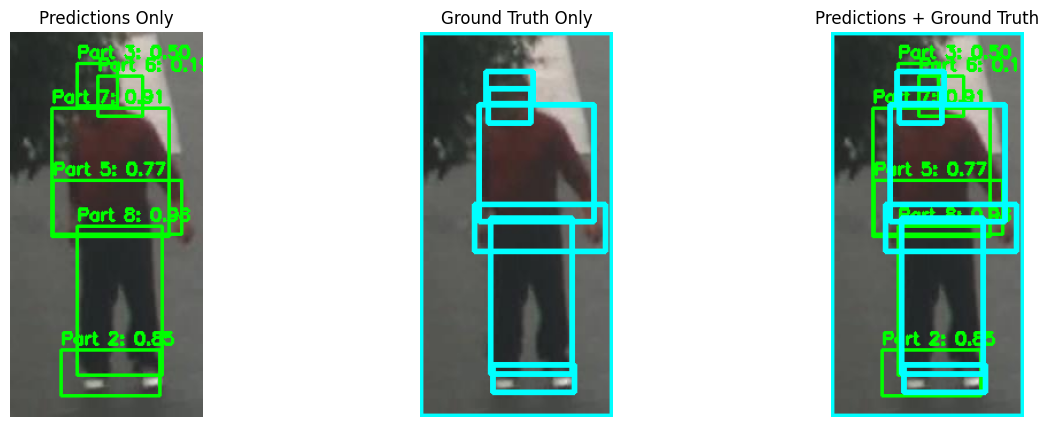

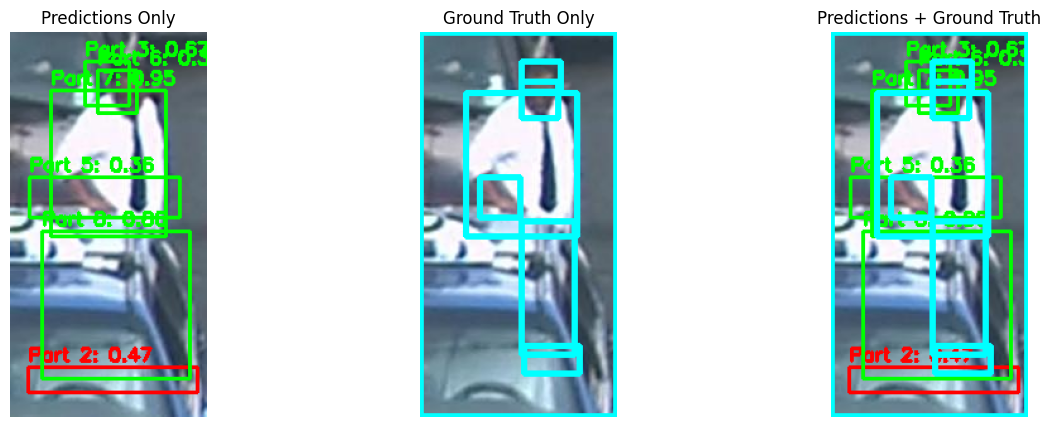

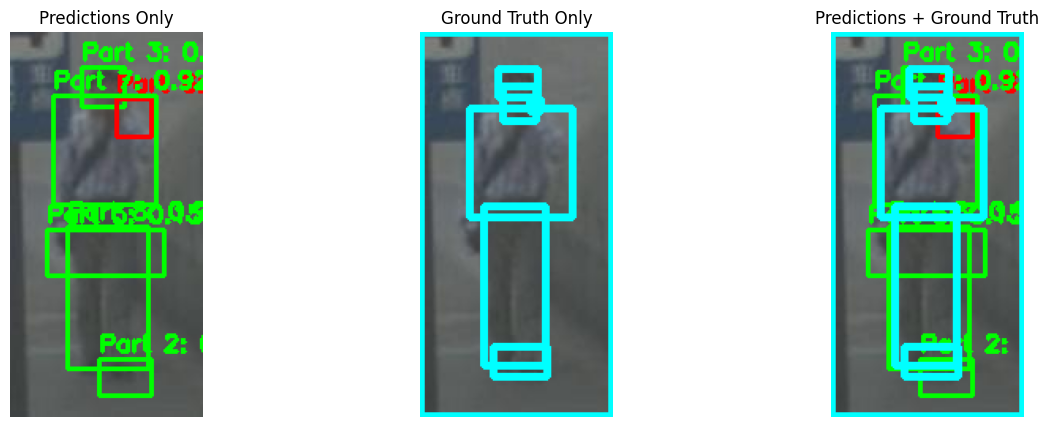

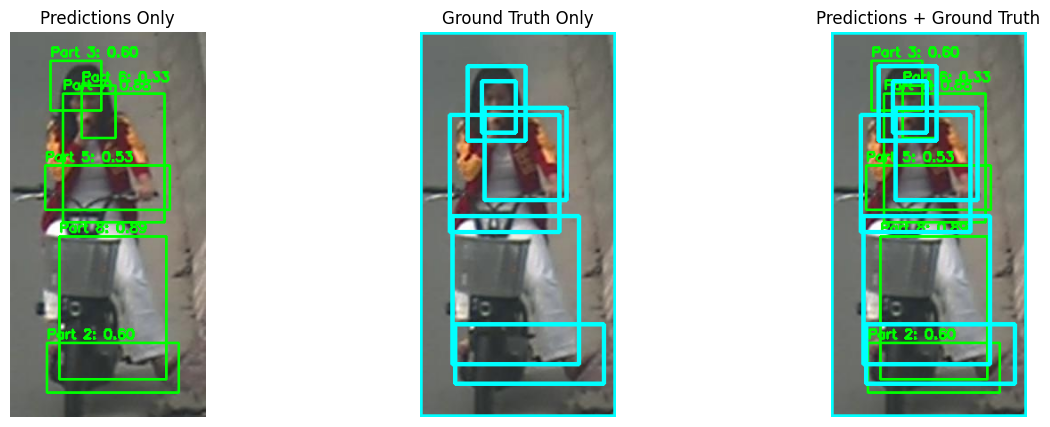

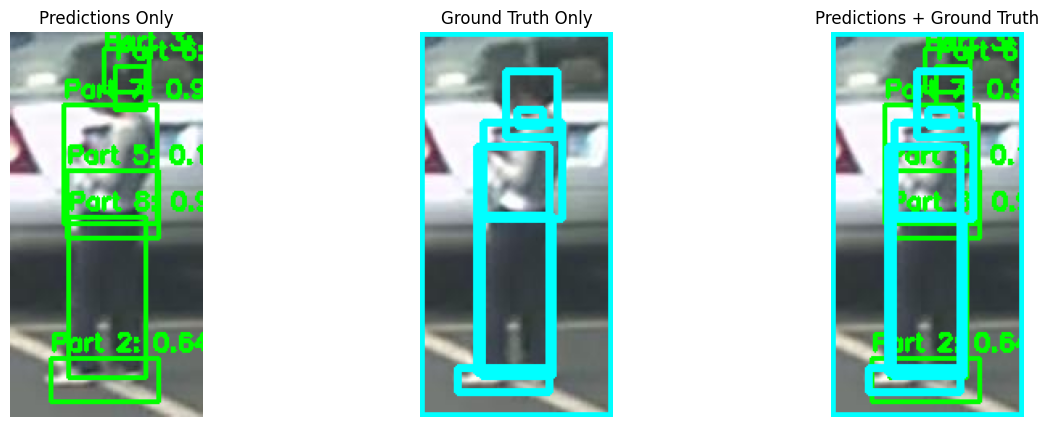

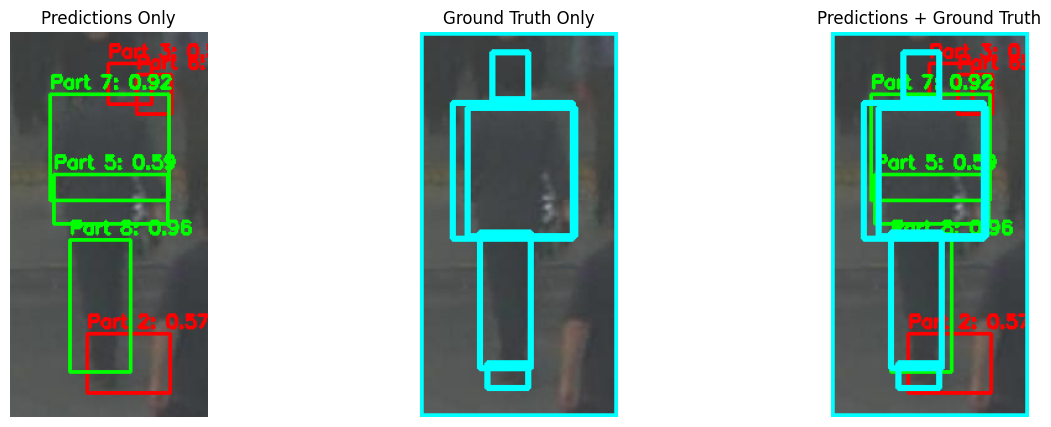

In [ ]:
def filter_highest_confidence_boxes(predictions):
    # Filters the predictions to keep only the highest confidence box per class
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    unique_labels = np.unique(pred_labels)
    filtered_boxes, filtered_labels, filtered_scores = [], [], []

    for label in unique_labels:
        indices = np.where(pred_labels == label)[0]
        best_index = indices[np.argmax(pred_scores[indices])]
        filtered_boxes.append(pred_boxes[best_index])
        filtered_labels.append(pred_labels[best_index])
        filtered_scores.append(pred_scores[best_index])
    return {
        "boxes": np.array(filtered_boxes),
        "labels": np.array(filtered_labels),
        "scores": np.array(filtered_scores)
    }

def visualize_predictions_with_errors(image, predictions, ground_truth):
    # Visualizes the predictions and ground truth boxes on the image
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    predictions = filter_highest_confidence_boxes(predictions)
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    gt_boxes = np.array(ground_truth["boxes"])
    gt_labels = np.array(ground_truth["labels"])
    if len(gt_boxes) > 0 and len(pred_boxes) > 0:
        ious = ops.box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
        max_ious, max_indices = ious.max(dim=1)
    else:
        max_ious = torch.zeros(len(pred_boxes))

    images = {
        "Predictions Only": image_np.copy(),
        "Ground Truth Only": image_np.copy(),
        "Predictions + Ground Truth": image_np.copy()
    }
    for i, box in enumerate(pred_boxes):
        box = box.astype(int)
        label = pred_labels[i]
        score = pred_scores[i]
        color = (0, 255, 0) if max_ious[i] >= 0.2 else (0, 0, 255)   
        for key in ["Predictions Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(images[key], f"Part {label}: {score:.2f}", (box[0], max(10, box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    for gt_box in gt_boxes:
        gt_box = gt_box.astype(int)
        for key in ["Ground Truth Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 255, 0), 3)   
    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(title)
    plt.show()

val_loader = DataLoader(vd, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
s = 0 
for (images, targets), pred, gt in zip(val_loader, preds, gts):
    image = images[0]   
    visualize_predictions_with_errors(image.cpu(), pred, gt)
    s += 1
    if s >= 10:
        break

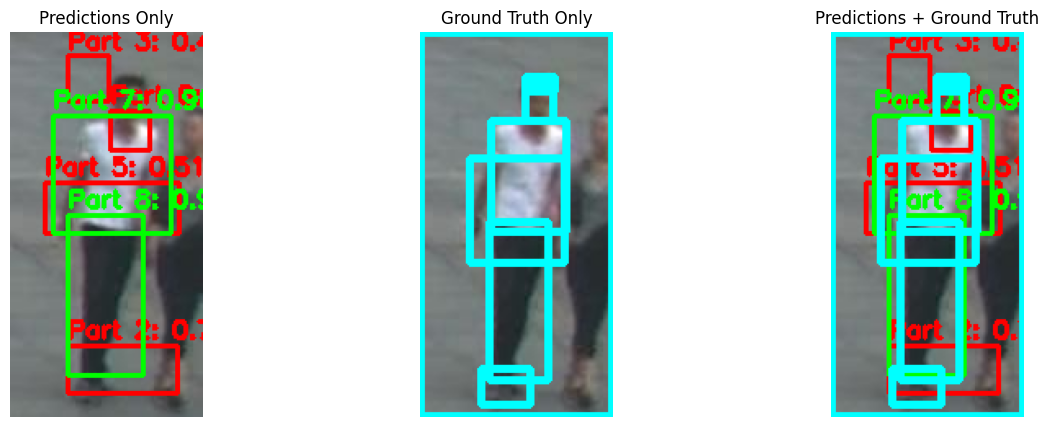

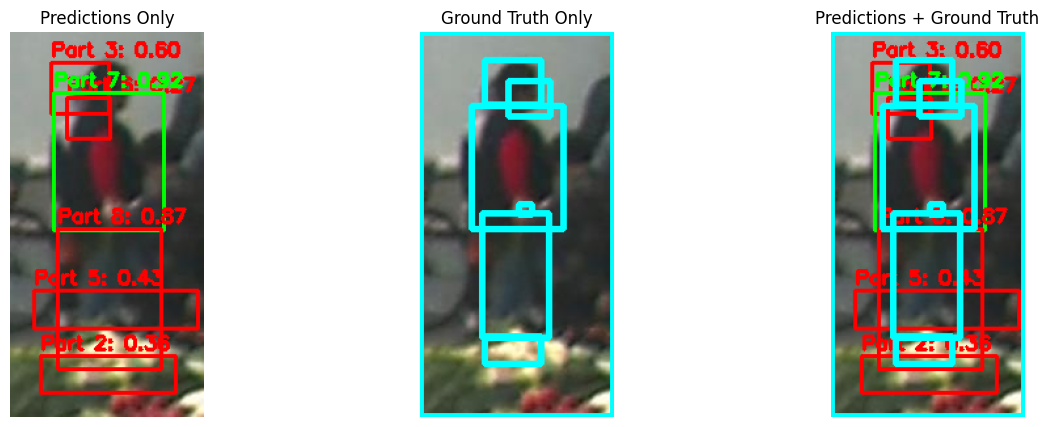

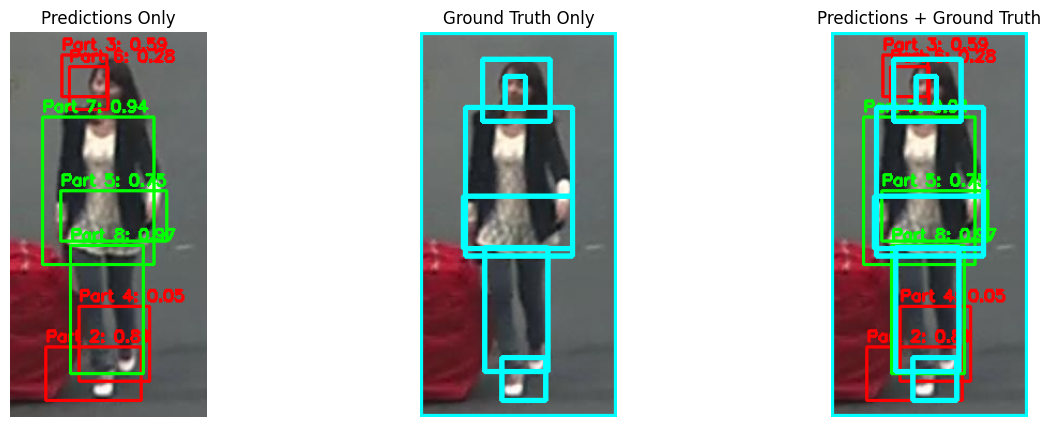

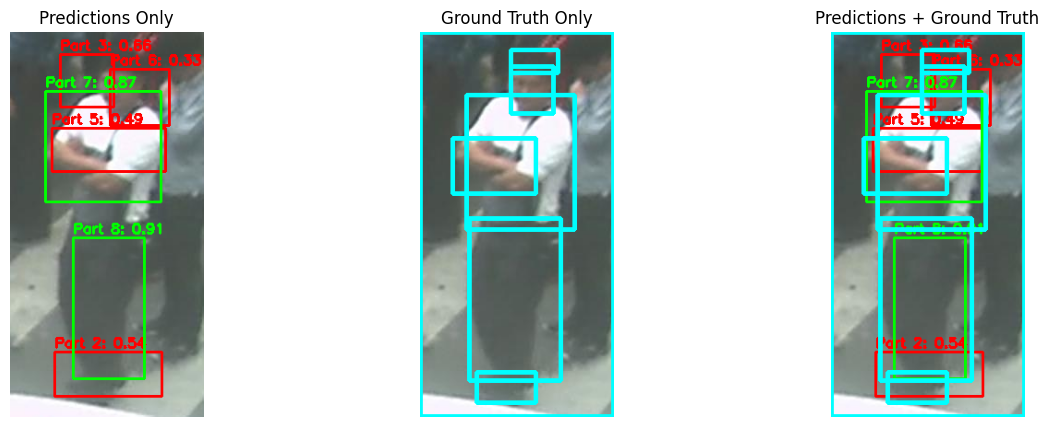

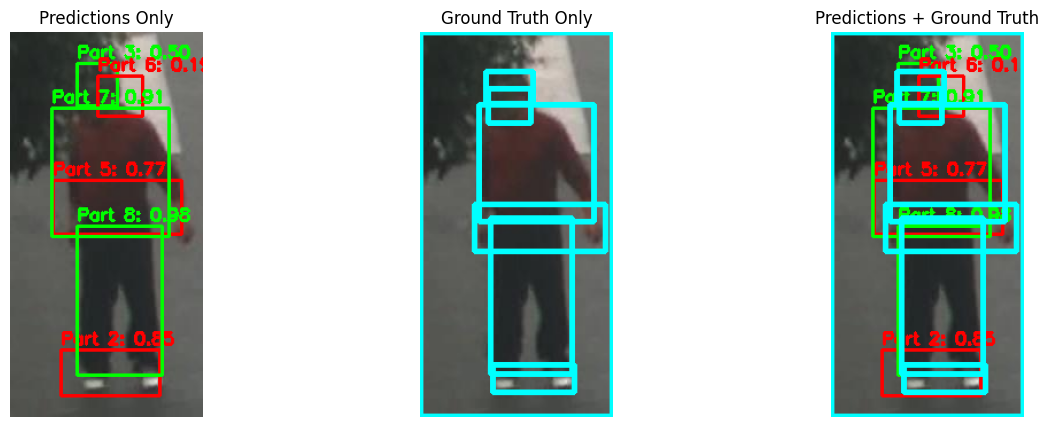

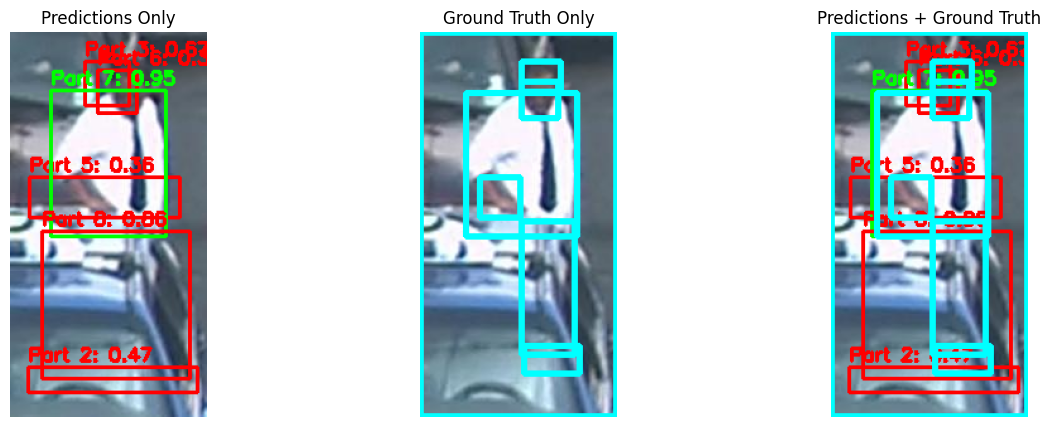

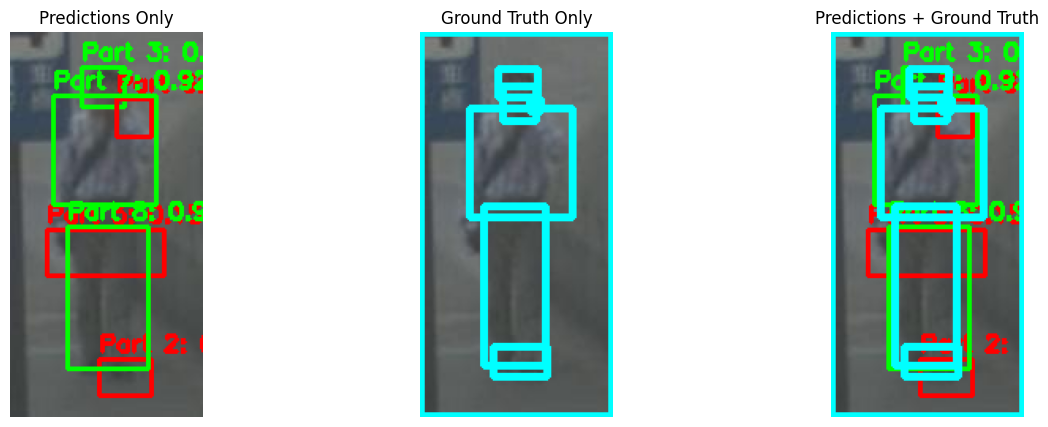

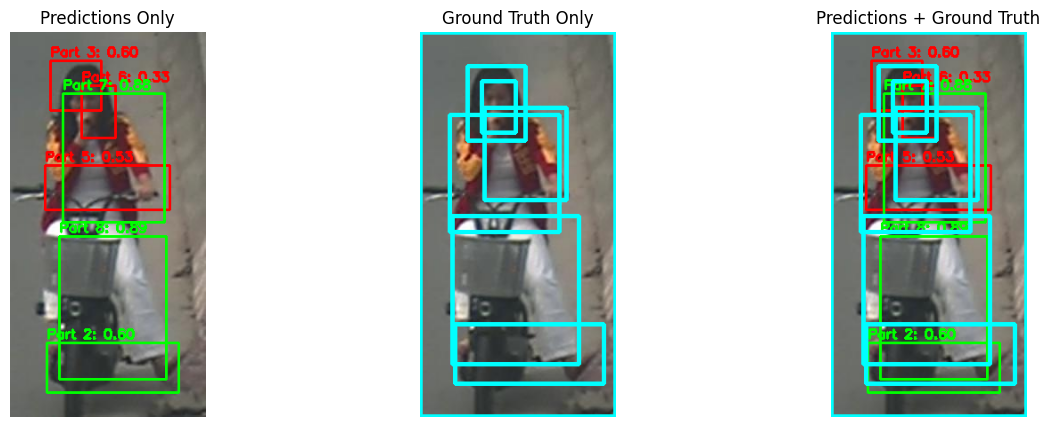

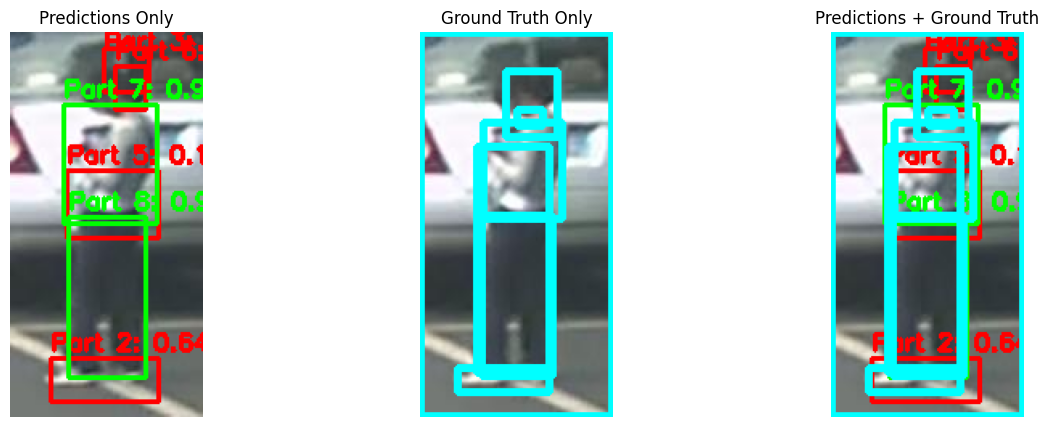

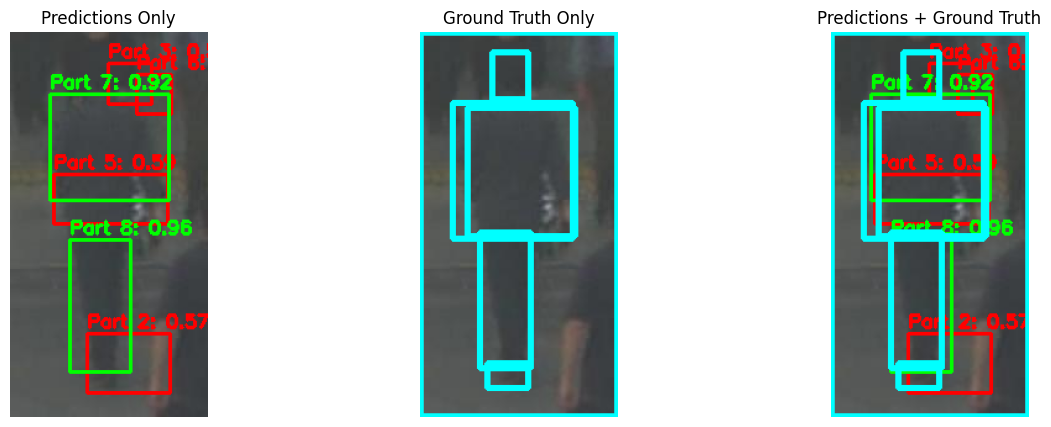

In [ ]:
def filter_highest_confidence_boxes(predictions):
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    unique_labels = np.unique(pred_labels)
    filtered_boxes, filtered_labels, filtered_scores = [], [], []
    for label in unique_labels:
        indices = np.where(pred_labels == label)[0]
        best_index = indices[np.argmax(pred_scores[indices])]
        filtered_boxes.append(pred_boxes[best_index])
        filtered_labels.append(pred_labels[best_index])
        filtered_scores.append(pred_scores[best_index])
    return {
        "boxes": np.array(filtered_boxes),
        "labels": np.array(filtered_labels),
        "scores": np.array(filtered_scores)
    }

def visualize_predictions_with_errors(image, predictions, ground_truth):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    predictions = filter_highest_confidence_boxes(predictions)
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    gt_boxes = np.array(ground_truth["boxes"])
    gt_labels = np.array(ground_truth["labels"])
    if len(gt_boxes) > 0 and len(pred_boxes) > 0:
        ious = ops.box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
        max_ious, max_indices = ious.max(dim=1)
    else:
        max_ious = torch.zeros(len(pred_boxes))
    images = {
        "Predictions Only": image_np.copy(),
        "Ground Truth Only": image_np.copy(),
        "Predictions + Ground Truth": image_np.copy()
    }
    for i, box in enumerate(pred_boxes):
        box = box.astype(int)
        label = pred_labels[i]
        score = pred_scores[i]
        color = (0, 255, 0) if max_ious[i] >= 0.5 else (0, 0, 255)   
        for key in ["Predictions Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(images[key], f"Part {label}: {score:.2f}", (box[0], max(10, box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    for gt_box in gt_boxes:
        gt_box = gt_box.astype(int)
        for key in ["Ground Truth Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 255, 0), 3)   
    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(title)
    plt.show()

val_loader = DataLoader(vd, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
s = 0 
for (images, targets), pred, gt in zip(val_loader, preds, gts):
    image = images[0]   
    visualize_predictions_with_errors(image.cpu(), pred, gt)
    s += 1
    if s >= 10:
        break

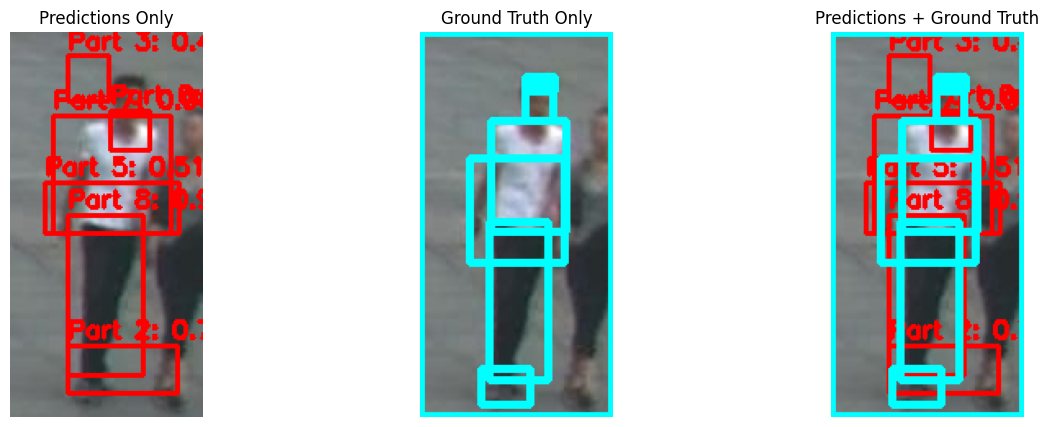

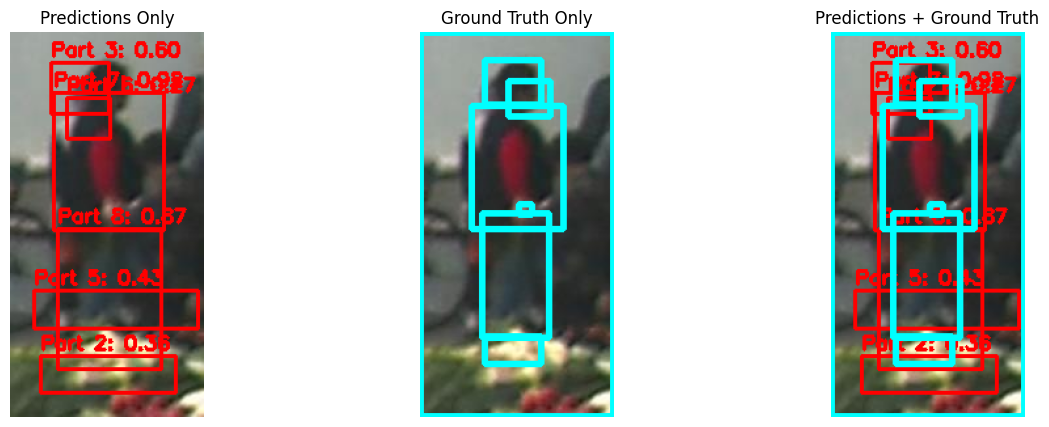

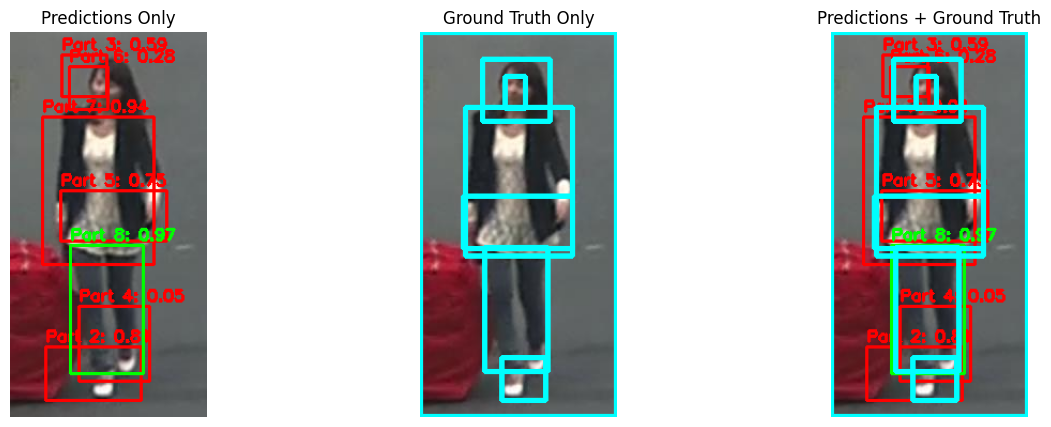

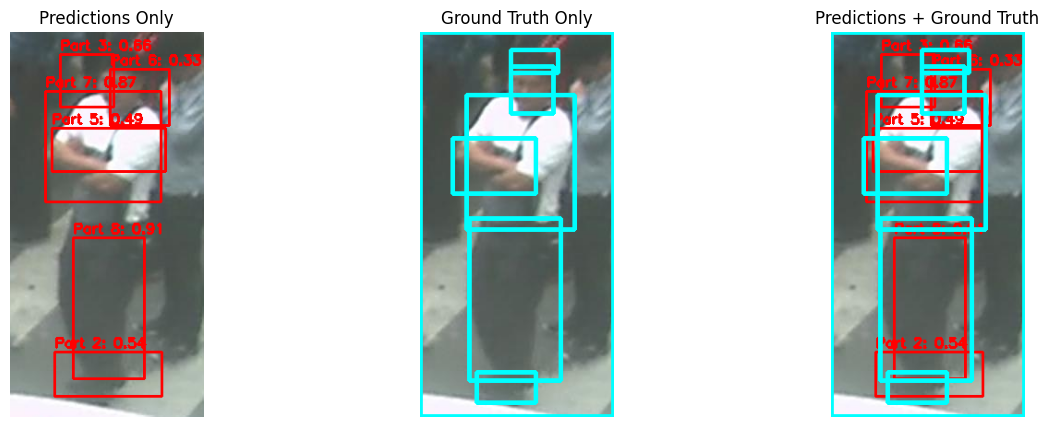

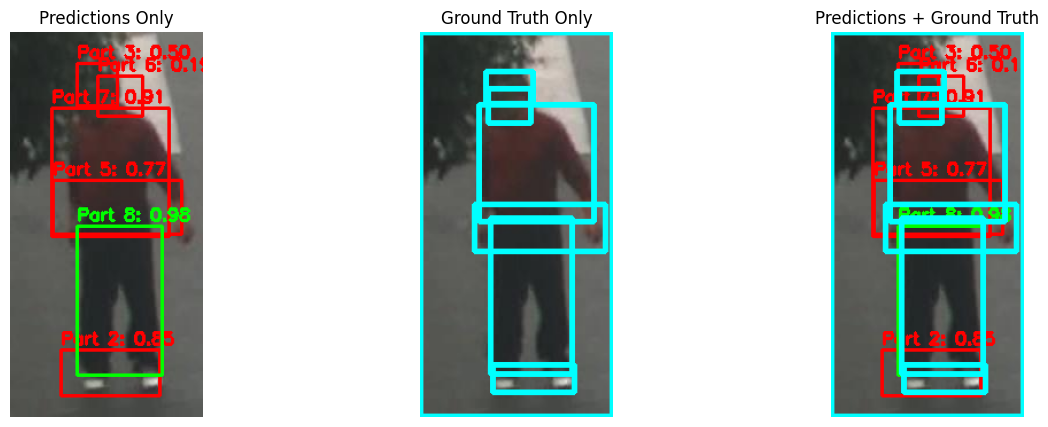

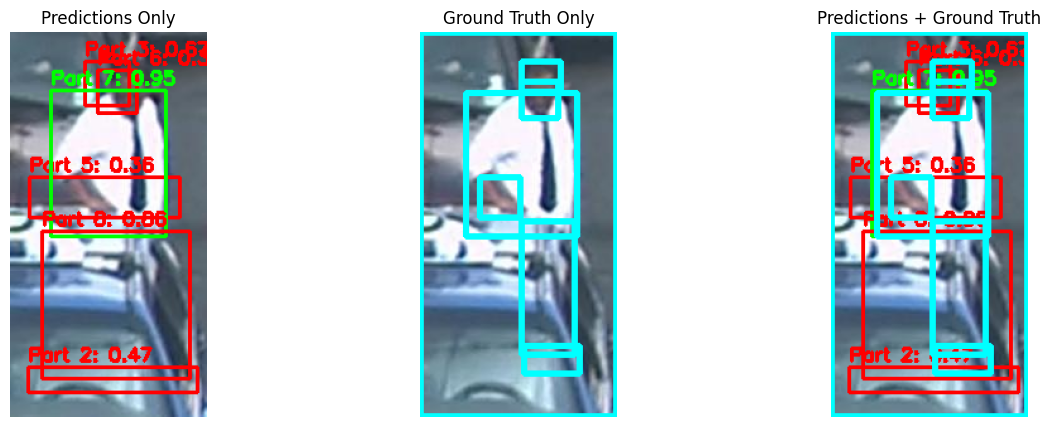

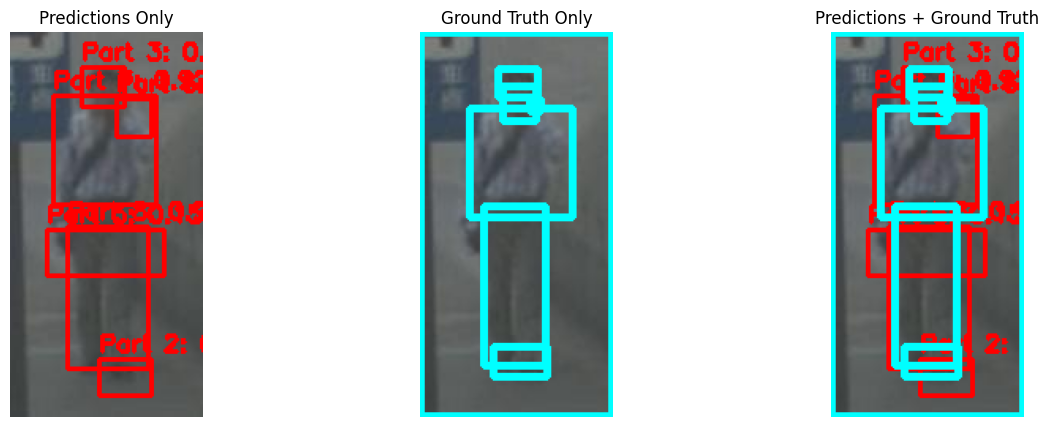

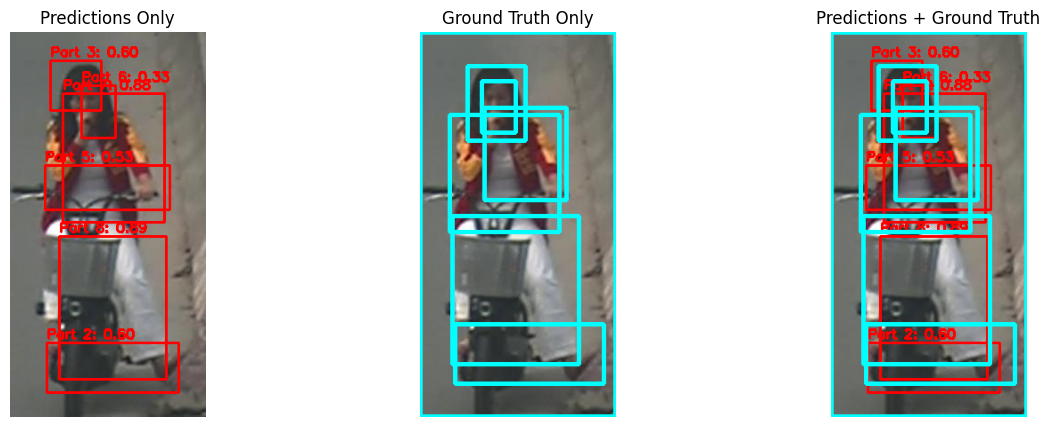

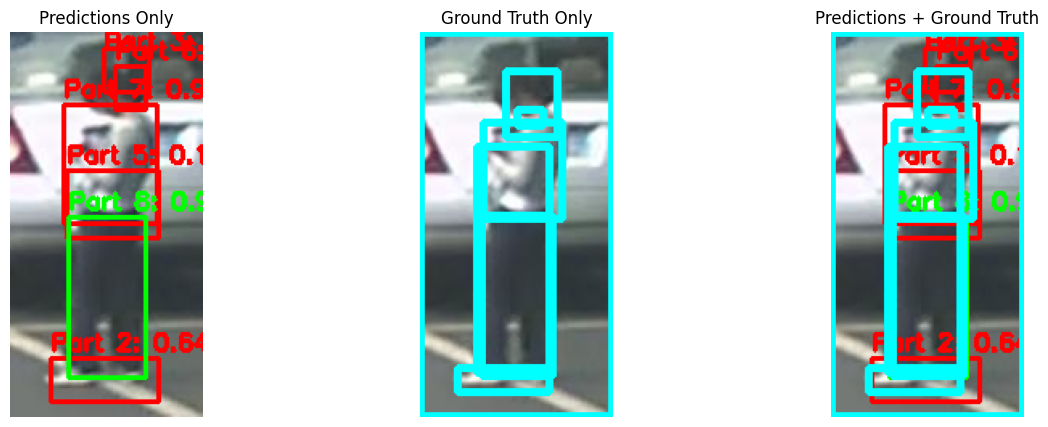

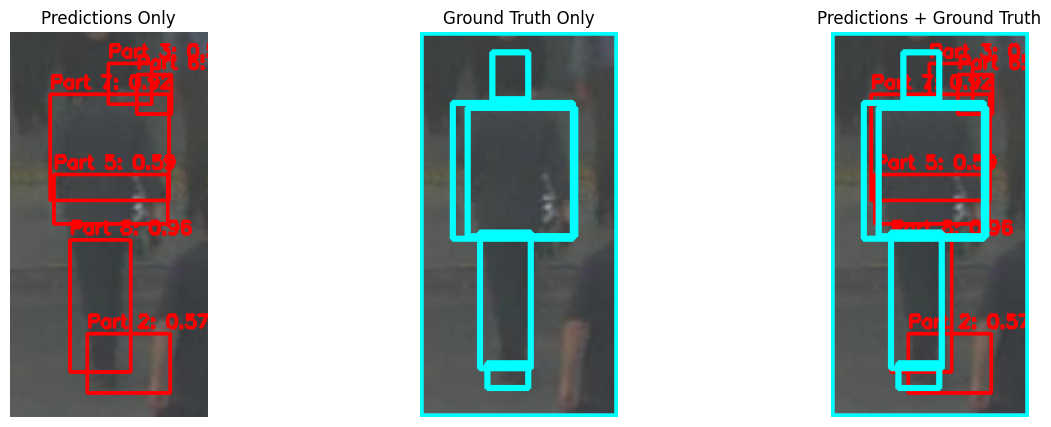

In [ ]:
def filter_highest_confidence_boxes(predictions):
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    unique_labels = np.unique(pred_labels)
    filtered_boxes, filtered_labels, filtered_scores = [], [], []
    for label in unique_labels:
        indices = np.where(pred_labels == label)[0]
        best_index = indices[np.argmax(pred_scores[indices])]
        filtered_boxes.append(pred_boxes[best_index])
        filtered_labels.append(pred_labels[best_index])
        filtered_scores.append(pred_scores[best_index])
    return {
        "boxes": np.array(filtered_boxes),
        "labels": np.array(filtered_labels),
        "scores": np.array(filtered_scores)
    }

def visualize_predictions_with_errors(image, predictions, ground_truth):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    predictions = filter_highest_confidence_boxes(predictions)
    pred_boxes = np.array(predictions["boxes"])
    pred_labels = np.array(predictions["labels"])
    pred_scores = np.array(predictions["scores"])
    gt_boxes = np.array(ground_truth["boxes"])
    gt_labels = np.array(ground_truth["labels"])
    if len(gt_boxes) > 0 and len(pred_boxes) > 0:
        ious = ops.box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
        max_ious, max_indices = ious.max(dim=1)
    else:
        max_ious = torch.zeros(len(pred_boxes))
    images = {
        "Predictions Only": image_np.copy(),
        "Ground Truth Only": image_np.copy(),
        "Predictions + Ground Truth": image_np.copy()
    }
    for i, box in enumerate(pred_boxes):
        box = box.astype(int)
        label = pred_labels[i]
        score = pred_scores[i]
        color = (0, 255, 0) if max_ious[i] >= 0.8 else (0, 0, 255)   
        for key in ["Predictions Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (box[0], box[1]), (box[2], box[3]), color, 2)
            cv2.putText(images[key], f"Part {label}: {score:.2f}", (box[0], max(10, box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    for gt_box in gt_boxes:
        gt_box = gt_box.astype(int)
        for key in ["Ground Truth Only", "Predictions + Ground Truth"]:
            cv2.rectangle(images[key], (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255, 255, 0), 3)   
    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate(images.items()):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(title)
    plt.show()

val_loader = DataLoader(vd, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
s = 0 
for (images, targets), pred, gt in zip(val_loader, preds, gts):
    image = images[0]   
    visualize_predictions_with_errors(image.cpu(), pred, gt)
    s += 1
    if s >= 10:
        break

In [ ]:
def compute_detailed_metrics(preds, gts, iou_thresh=0.5):
    # Computes precision, recall, F1-score, and AP per class.
    category_metrics = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0, "ious": []})
    for pred, gt in zip(preds, gts):
        pred_boxes = torch.tensor(pred["boxes"])
        pred_labels = torch.tensor(pred["labels"])
        pred_scores = torch.tensor(pred["scores"])
        gt_boxes = torch.tensor(gt["boxes"])
        gt_labels = torch.tensor(gt["labels"])
        if len(gt_boxes) == 0:
            continue
        ious = ops.box_iou(pred_boxes, gt_boxes)
        max_ious, max_indices = ious.max(dim=1)
        for idx, (iou, label) in enumerate(zip(max_ious, pred_labels)):
            matched_gt_label = gt_labels[max_indices[idx]]
            if iou >= iou_thresh and label == matched_gt_label:
                category_metrics[label.item()]["tp"] += 1
                category_metrics[label.item()]["ious"].append(iou.item())
            else:
                category_metrics[label.item()]["fp"] += 1
        for label in gt_labels:
            if label.item() not in pred_labels.tolist():
                category_metrics[label.item()]["fn"] += 1
    results = {}
    for label, counts in category_metrics.items():
        tp, fp, fn = counts["tp"], counts["fp"], counts["fn"]
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
        avg_iou = np.mean(counts["ious"]) if counts["ious"] else 0
        results[label] = {"Precision": precision, "Recall": recall, "F1-score": f1_score, "Avg IoU": avg_iou}
    return results

detailed_results = compute_detailed_metrics(preds, gts)
category_df = pd.DataFrame(detailed_results).T
print(category_df)

/tmp/ipykernel_33687/3937660474.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_boxes = torch.tensor(gt["boxes"])
/tmp/ipykernel_33687/3937660474.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_labels = torch.tensor(gt["labels"])


   Precision    Recall  F1-score   Avg IoU
8   0.216102  1.000000  0.355401  0.629968
7   0.236802  1.000000  0.382926  0.641478
2   0.075630  1.000000  0.140625  0.596336
5   0.053447  1.000000  0.101471  0.608381
3   0.089908  1.000000  0.164982  0.611397
6   0.050132  1.000000  0.095478  0.607004
1   0.000000  0.000000  0.000000  0.000000
4   0.095745  0.310345  0.146341  0.601193


In [ ]:
def analyze_part_size_impact(preds, gts, iou_thresh=0.5):
    # Compute IoU scores for different part sizes
    size_analysis = {"small": [], "medium": [], "large": []}
    for pred, gt in zip(preds, gts):
        gt_boxes = torch.tensor(gt["boxes"])
        pred_boxes = torch.tensor(pred["boxes"])
        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            continue
        ious = ops.box_iou(pred_boxes, gt_boxes)
        max_ious, _ = ious.max(dim=1)
        for gt_box, iou in zip(gt_boxes, max_ious):
            width = gt_box[2] - gt_box[0]
            height = gt_box[3] - gt_box[1]
            area = width * height
            category = "small" if area < 5000 else "medium" if area < 20000 else "large"
            size_analysis[category].append(iou.item())
    size_results = {size: np.mean(iou_list) if iou_list else 0 for size, iou_list in size_analysis.items()}
    return size_results

size_results = analyze_part_size_impact(preds, gts)
print("Impact of Part Size on IoU:", size_results)

/tmp/ipykernel_33687/3305744986.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_boxes = torch.tensor(gt["boxes"])


Impact of Part Size on IoU: {'small': np.float64(0.5010541336805558), 'medium': np.float64(0.44235699667506934), 'large': np.float64(0.6098060095404607)}


# **Comprehensive Model Performance Analysis**

---

## **1. Mean Average Precision (mAP) and IoU Performance**
The model's detection performance was assessed using **Mean Average Precision (mAP)** at different IoU thresholds:

| Metric  | Value  |
|---------|--------|
| **mAP (Overall)** | **0.0560** |
| **AP @ IoU 0.5** | **0.1003** |
| **AP @ IoU 0.75** | **0.0116** |

### **Observations**
- **High detection recall**, but **low precision**, suggesting many false positives.
- The **AP at IoU 0.75 is extremely low (0.0116)**, indicating **poor localization accuracy**.
- The model is capable of detecting objects but struggles with **bounding box precision**.

---

## **2. Performance Across Different Body Parts**
The table below summarizes the **precision, recall, F1-score, and average IoU** for each body part:

| Part | Precision | Recall | F1-score | Avg IoU |
|------|------------|---------|-----------|---------|
| **Part 8** | **0.2161** | **1.0000** | **0.3554** | **0.6299** |
| **Part 7** | **0.2368** | **1.0000** | **0.3829** | **0.6415** |
| **Part 2** | **0.0756** | **1.0000** | **0.1406** | **0.5963** |
| **Part 5** | **0.0534** | **1.0000** | **0.1015** | **0.6084** |
| **Part 3** | **0.0899** | **1.0000** | **0.1650** | **0.6114** |
| **Part 6** | **0.0501** | **1.0000** | **0.0955** | **0.6070** |
| **Part 1** | **0.0000** | **0.0000** | **0.0000** | **0.0000** |
| **Part 4** | **0.0957** | **0.3103** | **0.1463** | **0.6012** |

### **Key Takeaways**
- **High Recall for Most Parts:** The model **detects most parts** (Recall = **1.0**) but **misclassifies many of them**, leading to **low precision**.
- **Poor Precision:** The **low precision scores (0.05 - 0.23)** indicate a **high number of false positives**.
- **Complete Failure for Part 1:** Precision and recall are **0.0**, meaning this part is never detected.
- **IoU Scores Are Decent (~0.60 on Average):** Predictions **roughly overlap** with the ground truth but need better refinement.

---

## **3. Impact of Part Size on IoU**
The model’s IoU varies based on the size of detected body parts:

| Object Size | Avg IoU |
|-------------|---------|
| **Small** | **0.5011** |
| **Medium** | **0.4424** |
| **Large** | **0.6098** |

### **Findings**
- **Larger parts have higher IoU (~0.61)** because they are easier to detect.
- **Smaller parts suffer more (~0.50 IoU)**, likely due to anchor box misalignment and poor feature extraction.
- **Medium-sized parts (0.44 IoU) struggle the most**, indicating that mid-sized parts are neither small enough for fine-grained feature detection nor large enough for clear distinction.

---

## **4. Analysis of IoU-Based Detection Performance**

### **4.1 Extreme High IoU (First Image Set)**
**Observations:**
- Bounding boxes **strongly align** with ground truth.
- **Minimal false positives** or incorrect predictions.
- The model effectively **identifies parts with high accuracy**.

**Key Takeaway:**  
The model performs well when object features are **clear and bounding box sizes match learned anchor configurations**.

---

### **4.2 Moderate IoU (Second Image Set)**
**Observations:**
- Bounding boxes are **reasonably aligned** but **slightly shifted**.
- Some predicted boxes **overshoot or undershoot** actual part boundaries.
- Higher false positives compared to high IoU scenarios.

**Key Takeaway:**  
The model **captures general body part regions** but lacks **fine-grained spatial accuracy**, requiring:
- **Better anchor tuning**
- **Improved bounding box regression**

---

### **4.3 Low IoU (Third Image Set)**
**Observations:**
- **Significant misalignment** between predicted and ground truth boxes.
- **Large false positive rate**, with multiple incorrect detections.
- Some parts have **low confidence scores** and are misplaced.

**🔍 Key Takeaway:**  
The model struggles with **bounding box localization** and **over-predicts irrelevant regions**, indicating the need for:
- **Improved anchor box selection**
- **Better feature extraction for smaller parts**
- **Non-max suppression (NMS) tuning**

---

## **5. Failure Cases and Success Cases**
### **5.1 Success Cases**
The model works **well in high-contrast scenarios**, where body parts are **clearly visible and well-separated**.  
Large body parts **tend to be detected more accurately** due to stronger feature maps.  
**Straightforward poses** yield higher IoU scores and better precision.  

### **5.2 Failure Cases**
**Occlusion:**  
- The model **fails when parts overlap with each other**, confusing labels.  
- Some detected parts **merge into one box**, reducing accuracy.  

**Viewpoint Variations:**  
- The model **performs poorly on extreme angles**, indicating that it **has not learned pose variations effectively**.  
- Side views lead to **bounding box misalignment**.  

**Small Parts Detection:**  
- **Parts like hands and feet are often misclassified or missed entirely.**  
- Anchor box **sizes may not be optimal for small regions**.  

---

## **6. Final Verdict**
**Current performance is limited by low precision (0.05 - 0.23) and struggles with occlusion, small parts, and viewpoint variations.**  
However, the model shows **high recall (1.0 for most parts)** and **reasonable IoU (0.60 average for large parts).**  

# **Suggested Improvements for Parts Detection Model**

Potential improvements to enhance the model’s **accuracy, precision, and robustness**, focusing on **architectural modifications, alternative approaches, and hierarchical modeling strategies**.

---

## **1. Architectural Modifications for Better Parts Detection**
### **1.1 Use of a More Advanced Object Detection Model**
 **Switch to Transformer-Based Detection (DETR):**  
- **Why?** Faster R-CNN relies on region proposals, which can struggle with **small and overlapping objects**.  
- **Solution:** DETR (DEtection TRansformer) **eliminates anchor boxes** and directly predicts objects using self-attention, improving localization.  

 **Use YOLOv8 or EfficientDet:**  
- **Why?** Faster R-CNN is accurate but computationally expensive.  
- **Solution:** YOLOv8 or EfficientDet are **faster and optimized for small object detection**, making them better suited for real-time applications.  

### **1.2 Multi-Scale Feature Extraction with Swin Transformer**
- **Why?** Current **FPN (Feature Pyramid Network)** extracts features at multiple scales but **loses fine-grained spatial details**.  
- **Solution:** Replace **ResNet-50 with Swin Transformer** as the backbone, leveraging **window-based self-attention** for better fine-grained part segmentation.  

### **1.3 Trainable Anchor-Free Detection**
- **Why?** Fixed anchor boxes may not generalize well across **different body parts and aspect ratios**.  
- **Solution:** Use **anchor-free detectors (e.g., FCOS - Fully Convolutional One-Stage Detector)** that **learn object centers dynamically** instead of relying on predefined anchor sizes.  

---

## **2. Alternative Approaches for Handling Challenging Cases**
### **2.1 Handling Occlusion & Small Object Detection**
 **Occlusion-Aware Training:**  
- Use **self-supervised learning** to **pre-train the model on occluded images**, forcing it to learn object structures even when partially visible.  
- Introduce **occlusion augmentations** where part of the image is blurred or removed during training.  

 **Super-Resolution for Small Parts:**  
- Apply **image super-resolution** (e.g., ESRGAN) before detection to enhance **small part details**, improving their visibility to the model.  

 **Finer-Grained Feature Maps (HRNet):**  
- HRNet maintains **high-resolution feature maps** throughout the network, which helps **preserve small object features**, leading to **better small part detection**.  

---

### **2.2 Improved Post-Processing for Reducing False Positives**
 **Adaptive Non-Maximum Suppression (Adaptive-NMS):**  
- Standard NMS **removes overlapping predictions based on a fixed IoU threshold**, but some parts have **natural overlaps (e.g., arms and torso)**.  
- **Solution:** Adaptive-NMS **modifies the threshold dynamically** based on part location and size, **reducing unnecessary suppression of true detections**.  

 **Part-Specific Confidence Thresholding:**  
- Instead of using a **global confidence threshold**, apply **different thresholds per part** based on their detection reliability.  
- **Example:** If Part 1 has low precision, set a higher confidence threshold to reduce false positives.  

 **Graph-Based Refinement for Overlapping Parts:**  
- Use **graph-based post-processing** where detected parts are modeled as **nodes** in a graph.  
- If two detected parts **overlap too much**, apply **graph matching algorithms** to resolve which detection is more reliable.  

---

## **3. Incorporating Part Relationships & Hierarchical Structure**
### **3.1 Part-Whole Relationship Modeling**
 **Use Graph Neural Networks (GNNs) to Capture Spatial Relationships**  
- **Problem:** Current models **treat each part independently**, missing structural relationships (e.g., hands should be near the arms).  
- **Solution:** Use **Graph Neural Networks (GNNs)** where each detected part is a node, and edges **define spatial relationships** between parts.  
- **Example:** If a hand is detected without an arm nearby, the GNN can correct the detection using learned relationships.  

 **Pose-Guided Detection Using Human Keypoints**  
- **Problem:** Some parts (e.g., hands) are difficult to detect in isolation.  
- **Solution:** Use **pose estimation models (e.g., OpenPose, HRNet-Pose)** to predict **keypoints first**, then use them as priors for parts detection.  
- **Example:** If a wrist keypoint is detected, the model can **infer the hand's location** more accurately.  

---

### **3.2 Hierarchical Detection with a Two-Stage Model**
 **Stage 1: Full-Body Detection → Stage 2: Part-Specific Refinement**  
- Instead of detecting parts **independently**, first **detect the entire human body**, then **refine part localization using the detected body region**.  
- **Why?** This approach **reduces false positives** by ensuring that parts exist **only within valid human body regions**.  

 **Hierarchical Part Localization Using Cascaded R-CNN**  
- Train a **cascaded R-CNN** where:  
  - **First stage detects larger parts** (e.g., torso, legs).  
  - **Second stage refines smaller parts** (e.g., hands, fingers).  
- This ensures that **part detection depends on larger structures**, improving spatial coherence.  

---

## **4. Summary of Recommended Improvements**
| **Category** | **Proposed Improvement** | **Benefit** |
|-------------|--------------------------|-------------|
| **Architectural Modifications** | Use **DETR** or **YOLOv8** instead of Faster R-CNN | **Anchor-free detection, better for small parts** |
|  | Replace **ResNet-50 with Swin Transformer** | **Better fine-grained feature extraction** |
|  | Use **FCOS (Anchor-Free Detector)** | **Improves small object localization** |
| **Handling Occlusions & Small Parts** | Apply **super-resolution models (ESRGAN)** | **Enhances small part visibility** |
|  | Train with **occlusion-aware augmentations** | **Improves robustness to occlusions** |
| **Reducing False Positives** | Use **Adaptive-NMS** | **Better handling of overlapping parts** |
|  | Apply **graph-based part matching** | **Prevents duplicate and incorrect detections** |
| **Modeling Part Relationships** | Train a **Graph Neural Network (GNN)** | **Captures spatial dependencies between parts** |
|  | Use **Pose-Guided Detection (HRNet-Pose)** | **Improves localization of hard-to-detect parts** |
| **Hierarchical Detection** | Use a **Two-Stage Model (Body → Parts)** | **Reduces false positives, improves precision** |
|  | Train a **Cascaded R-CNN for finer parts** | **Ensures hierarchical part detection** |
